# Title
Predicting Game Newsletter Subscriptions based on Player Age Using K-Nearest Neighbors (Classification)

# Introduction
# Background 
At UBC, a research group in the Department of computer science led by Professor Frank Wood is investigating how people interact with video games. To perform the study, they have set up a Minecraft server that logs detailed data about player actions as they move through the virtual world. They have come up with 3 broad questions of interest to explore which I will choosing out of the 3 to explore. 

# Question 
Can a player’s age predict whether they will subscribe to a game-related newsletter in the MineCraft player dataset? 
- This question is based on the first broad question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

# Data Description 
The dataset used in this project, players.csv, has multiple variables representing player characteristics. For this project/specific question, we focused on the following 2 columns:
- Age: a numeric variable representing the player’s age
- Subscribe: a binary categorical variable revealing if the player is subscribed to the game newsletter (TRUE or FALSE)

Summary of the Cleaned Dataset
- Total observations: 194
- TRUE (subscribed): 143
= FALSE (not subscribed): 52

This imbalance requires addressing during modeling to ensure fair representation of both classes. 

Variable Summary 
- Age = numeric (dbl) 
- Subscribe = factor (fct)

Data Issues 
- Only one predictor (Age) was used, which is unlikely sufficient for capturing complex behaviour 
- Class imbalance (more TRUE over FALSE). This was addressed with upsampling during the prepossessing (recipe) step. But this can still provide overfitting risks
- With only 194 observations, the dataset is small, limiting the generalizability of results
- Only had one numeric variable, hard to have other predictors for classification model

# Method & Results 
I used a K-Nearest Neighbours (KNN) classification model to predict newsletter subscription (subscribe) from player age (Age). This method was chosen for its interpretability and ability to model non-linear relationships. 

In [1]:
library(tidyverse)
library(tidymodels)
library(themis)
library(dplyr)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Data Loading and Cleaning 
The dataset (players.csv) was first imported and cleaned:

In [2]:
players <- read_csv("players.csv")

data_filtered <- players |>
select(Age, subscribe) |>
filter(!is.na(Age), !is.na(subscribe)) |>
mutate(subscribe = as_factor(subscribe))
data_filtered

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,subscribe
<dbl>,<fct>
9,TRUE
17,TRUE
17,FALSE
21,TRUE
21,TRUE
17,TRUE
19,TRUE
21,FALSE
17,TRUE


I focused only on the Age and subscribe columns.If there were any missing values they were removed to ensure valid input for mdeling. 

To inspect class imbalance in the response variable:

In [3]:
data_filtered |>
  group_by(subscribe) |>
  summarize(count = n())

subscribe,count
<fct>,<int>
FALSE,52
TRUE,142


Result 
- TRUE (subscribed) = 142
- FALSE (not subscribed) = 52
This imbalance resulted in the use of upsampling during training

# Data Summary and Visualization 
I created a grouped bar plot to understand the relationship between age group and subscription status

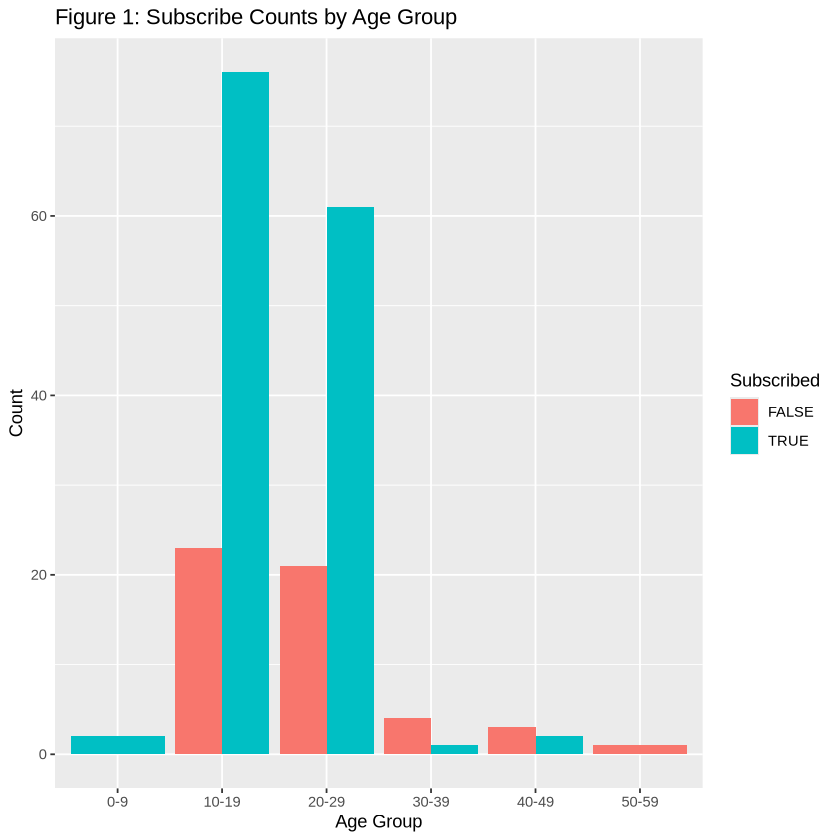

In [4]:
# Assuming your data_filtered has Age and subscribe columns
data_binned <- data_filtered |>
mutate(age_group = cut(Age, breaks = seq(0, 60, by = 10), right = FALSE,
                         labels = c("0-9", "10-19", "20-29", "30-39", "40-49", "50-59")))

ggplot(data_binned, aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "dodge") +  # dodge makes grouped bars
  labs(title = "Figure 1: Subscribe Counts by Age Group",
       x = "Age Group",
       y = "Count",
       fill = "Subscribed")

Figure 1 Insights:
- Most subscribers are aged 10-29 
- Subscription is rare among players under 10 or above 40
- Suggest some possible age-related trends, but doesn't confirm strong predictive strength

# Model Building and Evaluation 

Preprocessing 
I split the data (80% training, 20 % test)

In [46]:
set.seed(123)
data_split <- initial_split(data_filtered, prop = 0.8, strata = subscribe)
train_data <- training(data_split)
test_data <- testing(data_split)

A recipe was used to normalize Age and upsample the minority class

In [47]:
subscribe_recipe <- recipe(subscribe ~ Age, data = train_data) |>
  step_normalize(all_predictors()) |>
  step_upsample(subscribe, over_ratio = 1)

Then I tuned the k value using 5-fold cross vaildation. Also looked at the best k for accuracy, pericsion, and recall 
- decided to tuned k from 1 to 100 in steps of 5 (based on common themes in textbook). I used this step size to balance tuning resolution and efficiency, as testing every possible value would be costly for model with only one predictor. 

In [48]:
# Prep and bake just to view the normalized values
scaled_data <- subscribe_recipe |>
  prep() |>
  bake(new_data = NULL)

# View summary
summary(scaled_data)

      Age           subscribe  
 Min.   :-1.83210   FALSE:113  
 1st Qu.:-0.60138   TRUE :113  
 Median :-0.13986              
 Mean   : 0.06436              
 3rd Qu.: 0.32167              
 Max.   : 4.47536              

In [49]:
# Create 5-fold cross-validation splits stratified by subscribe
subscribe_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

# Define your KNN model specification with tuning neighbors
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Grid of k values to tune (choosing 1 to 100 by 5 through reference by textbook)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# Workflow with recipe + model
knn_wf <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(knn_spec)

# Metrics to collect: accuracy, precision, recall
metrics <- metric_set(accuracy, precision, recall)

# Tune grid and collect metrics
knn_results <- knn_wf |>
  tune_grid(resamples = subscribe_vfold, grid = k_vals, metrics = metrics) |>
  collect_metrics()

# Filter and view metrics for neighbors tuning
print(knn_results)

# Find best k based on precisionaccuracy (or choose another metric like precision)
best_accuracy_k <- knn_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)
best_accuracy_k

→ A | warning: While computing binary `precision()`, no predicted events were detected (i.e.
               `true_positive + false_positive = 0`).
               Precision is undefined in this case, and `NA` will be returned.
               Note that 8 true event(s) actually occurred for the problematic event level,
               FALSE

There were issues with some computations   A: x1

There were issues with some computations   A: x1





# A tibble: 60 × 7
   neighbors .metric   .estimator  mean     n std_err .config              
       <dbl> <chr>     <chr>      <dbl> <int>   <dbl> <chr>                
 1         1 accuracy  binary     0.349     5  0.0471 Preprocessor1_Model01
 2         1 precision binary     0.254     5  0.0275 Preprocessor1_Model01
 3         1 recall    binary     0.728     5  0.0490 Preprocessor1_Model01
 4         6 accuracy  binary     0.370     5  0.0222 Preprocessor1_Model02
 5         6 precision binary     0.273     5  0.0150 Preprocessor1_Model02
 6         6 recall    binary     0.828     5  0.0643 Preprocessor1_Model02
 7        11 accuracy  binary     0.403     5  0.0374 Preprocessor1_Model03
 8        11 precision binary     0.288     5  0.0167 Preprocessor1_Model03
 9        11 recall    binary     0.833     5  0.0574 Preprocessor1_Model03
10        16 accuracy  binary     0.397     5  0.0264 Preprocessor1_Model04
# ℹ 50 more rows


[1] 76

In [50]:
# Best k by precision
best_precision_k <- knn_results |>
  filter(.metric == "precision") |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

# Best k by recall
best_recall_k <- knn_results |>
  filter(.metric == "recall") |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)

best_precision_k
best_recall_k

[1] 76

[1] 26

I choose k = 76 based on highest accuracy because my goal was to maximize the correct oredicitions across both classes.

# Final Model Performance
using k = 76, I evaluated the model on the test set

In [51]:
final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_accuracy_k) |>
  set_engine("kknn") |>
  set_mode("classification")

final_workflow <- workflow() |>
  add_recipe(subscribe_recipe) |>
  add_model(final_spec)

final_fit <- final_workflow |>
  fit(data = train_data)

final_predictions <- predict(final_fit, test_data) |>
  bind_cols(test_data)

# Evaluate performance
metrics <- metrics(final_predictions, truth = subscribe, estimate = .pred_class)
metrics

# Confusion matrix
conf_mat <- conf_mat(final_predictions, truth = subscribe, estimate = .pred_class)
conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6500000
precision,binary,0.3333333
recall,binary,0.2727273


          Truth
Prediction FALSE TRUE
     FALSE     3    6
     TRUE      8   23

- Accuracy was moderate (~65%) but likely is small due to class imbalance 
- Percision and recall were both low, revealing poor ability to
identify actual subscribers
- The model frequency misclassified non-subscribers as subscribers 

# Why KNN? 

To address class imabalnce, I upsampled the minority class in the training set. I also normalized the predictor (Age) to prevent scale problems. 


For this analysis, the K-Nearest Neighbors (KNN) classification method was chosen because it is a straightforward approach well-suited for predicting categorical outcomes based on continuous predictors like age. KNN assumes that similar data points will have similar response values. The predictor variable (age) was scaled properly and data is representative of the population. 

However, ;imitations of KNN include sensitivity to the choice of k, potential bias from class imbalance (that still might be present), and reduced interpretability compared to parametric models. 

To select the best model, I performed 5-fold cross-validation on the training data, tuning k values from 1 to 100 to optimize accuracy (and as seen through class/textbook readings). The data was split into 80% training and 20% testing sets  on the subscription status to determine class proportions. Upsampling of the minority class was applied during training to address imbalance, and normalization was used to ensure meaningful distance calculations. 

This approach balances model evaluation with practical data considerations in this certain dataset. 

# Discussion 

# Summary of Findings
- Age is a weak standalone predictor of newsletter subscription
- Final KNN model (k = 76) showcased:
  - Accuracy: ~ 0.65
  - Precision: ~ 0.33
  - Recall: ~ 0.27
- Predictions are overestimating subscriptions
- Age trends: Most subscribers were aged 10–29; very few under 10 or over 40 subscribed. Not a strong enough relationship to reveal that Age is related to subscribers
- Upsampling created a 1:1 ratio (113 TRUE, 113 FALSE), helping reduce model bias.
- Confusion matrix shows high false predictions; low precision and recall suggest age alone is a weak predictor. This was also mentioned in the "warning" message

# Unexpected Challenges
- Despite balancing up upsampling, performance was limited
- A warning occured in cross-validation: precision was undefinded in some folds because no FALSE observations were predicted. This means difficulty detecting the minority classes and reinforces concerns about imbalance and limited predictors 

# Reflection 
- While I follwed what we learnt in class for workflow, the limited number of features affected results/peformance
- The method was done correctlt and followrd all standard preprocessing and evaluation processes 

# Impact 
- Age alone should not be used for targeting recruitment or any marketing
- Developers should combine age with other features (behavioral ones) for improved predicitions about players' data

# Future Directions 
- Include more variables like total session time, number of sessions, and types of actions
- Try different models like regression
- Maybe try to use cluster analysis to define distinct player segments

 # References

Sanderson II, S. P. (2024, March 19). Mastering Data Segmentation: A Guide to Using the cut() Function in R | R-bloggers. R-Bloggers. https://www.r-bloggers.com/2024/03/mastering-data-segmentation-a-guide-to-using-the-cut-function-in-r/

Timbers, T., Campbell, T., & Lee, M. (2022). Data Science A First Introduction. Routledge & CRC Press. https://datasciencebook.ca/